In [1]:
from carla import Benchmark
from IPython.display import display
import carla.evaluation.catalog as evaluation_catalog
from carla.data.catalog import OnlineCatalog
from carla.models.catalog import MLModelCatalog
from carla.models.negative_instances import predict_negative_instances
import carla.recourse_methods.catalog as recourse_catalog
import shap 
from sklearn.preprocessing import OrdinalEncoder
from carla.data.causal_model import CausalModel
import shap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from carla.data.catalog import CsvCatalog
import numpy as np 

import warnings
warnings.filterwarnings("ignore")

/home/jacqueline/.local/share/virtualenvs/CARLA-koH0yuP4/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/jacqueline/.local/share/virtualenvs/CARLA-koH0yuP4/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/jacqueline/.local/share/virtualenvs/CARLA-koH0yuP4/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint

[INFO] Using Python-MIP package version 1.12.0 [model.py <module>]


In [2]:
# Load the causal model
scm = CausalModel("credit")

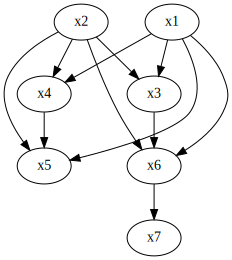

In [3]:
#Visualize the model
scm.cgm.draw()

In [4]:

#Generate Data from Causal Graph
dataset = scm.generate_dataset(1000)
dataset.df.to_csv('credit_synthetic.csv',index=False)
display(dataset.df)

,label,x1,x2,x3,x4,x6,x5,x7
0,1.0,0.0,3.397051,-0.040466,0.188113,-2.853309,-0.056990,3.908160
1,1.0,0.0,17.793393,-0.163504,-0.837680,4.533176,-0.314745,8.131771
2,0.0,0.0,-2.802867,-0.123910,1.518897,1.290734,2.294089,-8.192429
3,1.0,1.0,-5.288477,-0.108031,1.263543,-0.489085,5.488899,4.242939
4,1.0,0.0,16.303859,-0.015351,1.195834,4.138787,1.757983,-4.666042
...,...,...,...,...,...,...,...,...
995,0.0,0.0,-14.686998,-0.286660,-7.247662,-0.859396,-11.929608,-13.097775
996,0.0,0.0,-15.997002,-0.249561,-0.458157,-2.577439,-13.036919,-7.050404
997,1.0,1.0,16.513357,-0.059398,-0.084656,2.033270,2.486775,7.529237
998,1.0,1.0,24.968142,-0.031890,-2.018651,3.758463,-0.043503,2.604515


In [5]:
# Build Dataset usable with Wachter
import pandas as pd
# Load Data 
dataframe = pd.read_csv('./credit_synthetic.csv')
continuous = dataframe.drop(columns=['label']).columns

dataset = CsvCatalog(file_path="credit_synthetic.csv",
                     continuous=continuous,
                     categorical=[],
                     immutables=[],
                     target='label')

In [6]:
#Model 

training_params = {"lr": 0.01, "epochs": 3, "batch_size": 16, "hidden_size": [18, 9, 2]}

ml_model = MLModelCatalog(
    dataset, model_type="ann", load_online=False, backend="pytorch"
)
ml_model.train(
    learning_rate=training_params["lr"],
    epochs=training_params["epochs"],
    batch_size=training_params["batch_size"],
    hidden_size=training_params["hidden_size"],
    force_train=True
)


balance on test set 0.48933333333333334, balance on test set 0.512
Epoch 0/2
----------
train Loss: 0.6858 Acc: 0.5853

test Loss: 0.6332 Acc: 0.6960

Epoch 1/2
----------
train Loss: 0.5910 Acc: 0.7147

test Loss: 0.5296 Acc: 0.7960

Epoch 2/2
----------
train Loss: 0.4761 Acc: 0.8027

test Loss: 0.4145 Acc: 0.8480



In [7]:

from carla.models.negative_instances import predict_negative_instances
import carla.recourse_methods.catalog as recourse_catalog

# Find Factuals
factuals = predict_negative_instances(ml_model, dataset.df)
test_factual = factuals.iloc[:25]

display(test_factual)

,label,x1,x2,x3,x4,x6,x5,x7
0,1.0,0.0,0.426373,0.441288,0.532526,0.267621,0.505929,0.684383
2,0.0,0.0,0.325281,0.331484,0.600641,0.554987,0.568483,0.346572
3,1.0,1.0,0.284752,0.352379,0.587571,0.431567,0.653485,0.693729
10,0.0,0.0,0.354755,0.345386,0.486375,0.457458,0.421985,0.418249
14,0.0,0.0,0.371151,0.300334,0.649358,0.424706,0.571012,0.504250
15,1.0,0.0,0.450260,0.033095,0.629604,0.360440,0.511894,0.648565
17,1.0,1.0,0.291022,0.294433,0.545914,0.498596,0.559711,0.699538
18,1.0,1.0,0.280107,0.435865,0.590811,0.247067,0.641397,0.545997
20,0.0,0.0,0.346507,0.228290,0.518979,0.615482,0.482370,0.572586
22,0.0,1.0,0.148899,0.280159,0.314225,0.580427,0.314377,0.598107


In [8]:
#Find Counterfactuals
hyperparams = {"loss_type": "BCE"}

recourse_method = recourse_catalog.Wachter(ml_model, hyperparams)
cfs = recourse_method.get_counterfactuals(test_factual)


[INFO] Counterfactual Explanation Found [wachter.py wachter_recourse]
[INFO] Counterfactual Explanation Found [wachter.py wachter_recourse]
[INFO] Counterfactual Explanation Found [wachter.py wachter_recourse]
[INFO] Counterfactual Explanation Found [wachter.py wachter_recourse]
[INFO] Counterfactual Explanation Found [wachter.py wachter_recourse]
[INFO] Counterfactual Explanation Found [wachter.py wachter_recourse]
[INFO] Counterfactual Explanation Found [wachter.py wachter_recourse]
[INFO] Counterfactual Explanation Found [wachter.py wachter_recourse]
[INFO] Counterfactual Explanation Found [wachter.py wachter_recourse]
[INFO] Counterfactual Explanation Found [wachter.py wachter_recourse]
[INFO] Counterfactual Explanation Found [wachter.py wachter_recourse]
[INFO] Counterfactual Explanation Found [wachter.py wachter_recourse]
[INFO] Counterfactual Explanation Found [wachter.py wachter_recourse]
[INFO] Counterfactual Explanation Found [wachter.py wachter_recourse]
[INFO] Counterfactua

In [9]:
def get_pred_from_causal(scm,values,cf_label, mapping_dict):
    '''
    Infers the prediction from the causal model
    Attributes: 
        scm: structural causal model 
        values: The counterfactual 
        cf_label: The counterfactual label 
        mapping_dict: variable name mapping betwenn CF and causal model
    Returns Label
    '''
    values['target']=cf_label
    #print(values)
    def _get_noise_string(node):
        def _get_node_id(node):
            return node[1:]
        if not node[0] == "x":
            raise ValueError
        return "u" + _get_node_id(node)
    exogenous_variables = np.concatenate(
        [
            #np.array(scm.noise_distributions[node].sample(1)).reshape(-1, 1)
            np.array(values[mapping_dict[node]]).reshape(-1, 1)
            for node in scm.get_topological_ordering("exogenous")
        ],
        axis=1,
    )
    exogenous_variables = pd.DataFrame(
        exogenous_variables, columns=scm.get_topological_ordering("exogenous")
    )

    endogenous_variables =exogenous_variables.copy() # np.array(values[mapping_dict[node]]).reshape(-1, 1)
    endogenous_variables = endogenous_variables.rename(
        columns=dict(
            zip(
                scm.get_topological_ordering("exogenous"),
                scm.get_topological_ordering("endogenous"),
            )
        )
    )
    # used later to make sure parents are populated when computing children
    endogenous_variables.loc[:] = np.nan
    for node in scm.get_topological_ordering("endogenous"):
        #print(node)
        parents = scm.get_parents(node)
        if endogenous_variables.loc[:, list(parents)].isnull().values.any():
            raise ValueError(
                "parents in endogenous_variables should already be occupied"
            )
        #print(_get_noise_string(node))
        endogenous_variables[node] = scm.structural_equations_np[node](
            exogenous_variables[_get_noise_string(node)],
            *[endogenous_variables[p] for p in parents],


        )
    # fix a hyperplane
    w = np.ones((endogenous_variables.shape[1], 1))
    # get the average scale of (w^T)*X, this depends on the scale of the data
    scale = 2.5 / np.mean(np.abs(np.dot(endogenous_variables, w)))
    predictions = 1 / (1 + np.exp(-scale * np.dot(endogenous_variables, w)))

    uniform_rv = np.random.rand(endogenous_variables.shape[0], 1)
    labels = int(uniform_rv < predictions)
    
    return labels

In [10]:
mapping_dict={ 
    # Gender
      'u1': 'x1',
      # Age
      'u2': 'x2',
      # Education
      'u3': 'x3',
      # Loan amount
      'u4':'x4',
      # Loan duration
      'u5': 'x5',
      # Income
      'u6': 'x6',
      # Savings
      'u7':'x7',
}

In [11]:
from cmath import nan
from telnetlib import SE
from carla.data import causal_model
from carla.evaluation import remove_nans
from carla.evaluation.api import Evaluation
class Sematic(Evaluation):
    """
    Semnatic Evaluation Metric.
    Attributes: 
        ml_model: Machine Learning Model
        causal_graph: ground truth causal graph
        mapping_dict: name mapping
    Returns: Consistency
    """

    def __init__(self, ml_model, causal_graph,mapping_dict):
        self.ml_model= ml_model
        self.causal_graph=causal_graph
        self.mapping_dict=mapping_dict
    def get_evaluation(self,factuals: np.ndarray, counterfactuals: np.ndarray):
        # generate data 
        cf_label=self.ml_model.predict(np.array(counterfactuals.values).reshape(-1,counterfactuals.values.shape[-1]))
        print('cflabel', cf_label)
        if cf_label[0][0] > 0.5: 
            cf_label=1
        else:
            cf_label=0
        causal_label=get_pred_from_causal(self.causal_graph,counterfactuals,cf_label, self.mapping_dict)
        if cf_label ==causal_label:
            return pd.DataFrame([[1]], columns=["semantic"])
        else: 
            return pd.DataFrame([[0]], columns=["semantic"])

# Run metric for the generated counterfactuals 
results=[]
i=0

for a in test_factual.index:

    if str(cfs.iloc[i]['x1'])=='nan':
        pass
    else:
        sem= Sematic(ml_model,scm,mapping_dict)
        try:
            res=sem.get_evaluation(test_factual.iloc[a],cfs.iloc[i])['semantic'][0]
            results.append( res)
        except: 
            pass
    i=i+1

'''
This is the CARLA Way --> not used as the CF were created previously and therefore do not need to be recreated
'''
#benchmark = Benchmark(ml_model, recourse_method, factuals[:20])

# now you can decide if you want to run all measurements
# or just specific ones.
#evaluation_measures = [
#    Sematic(ml_model,scm,mapping_dict)
#]

#results = benchmark.run_benchmark(evaluation_measures)
results


cflabel [[0.516347]]
cflabel [[0.52036315]]
cflabel [[0.52445024]]
cflabel [[0.50316715]]
cflabel [[0.5058209]]
cflabel [[0.5229139]]
cflabel [[0.5040144]]
cflabel [[0.51248294]]
cflabel [[0.50065756]]
cflabel [[0.51827776]]


[1, 0, 0, 0, 0, 0, 0, 0, 0, 1]

In [12]:
# Averaging of the reults
mean= np.mean(results)
std= np.std(results)
print(f'Semantic results {mean} +/- {std}')

Semantic results 0.2 +/- 0.4000000000000001


In [13]:
# Building Probability Distribution of the output divided into complient/ not complient
import seaborn as sns 
import matplotlib.pyplot as plt 
# Data Distribution
id_comp= np.where(np.array(results)==1)
id_not_comp=np.where(np.array(results)==0)
print(id_not_comp)
if len(id_comp[0])==0:
    cfs_complient=[]
    cfs_complient_predict=[]
    
else:
    cfs_complient=cfs.iloc[id_comp[0]]
    cfs_complient_predict=np.max(ml_model.predict(np.array(cfs_complient.values).reshape(-1,cfs_complient.values.shape[-1])),axis=1)
cfs_not_complient=cfs.iloc[id_not_comp[0]]


cfs_not_complient_predict=np.max(ml_model.predict(np.array(cfs_not_complient).reshape(-1,7)),axis=1)


(array([1, 2, 3, 4, 5, 6, 7, 8]),)


[0.52036315 0.52445024 0.50316715 0.5058209  0.5229139  0.5040144
 0.51248294 0.50065756]


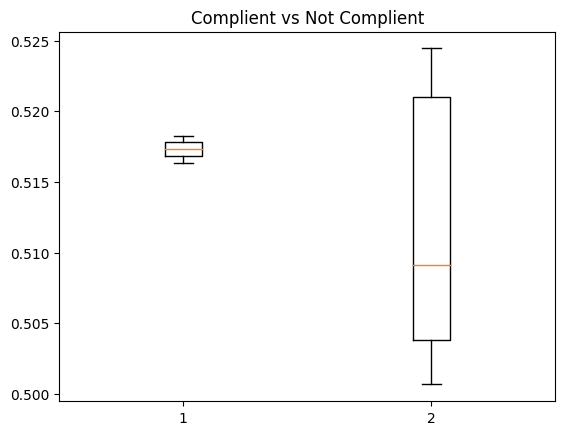

In [14]:
#BoxPlot
import  numpy
from math import nan, isnan
cfs_complient_predict = [x for x in cfs_complient_predict if isnan(x) == False]
cfs_not_complient_predict = [x for x in cfs_not_complient_predict if isnan(x) == False]
cfs_complient_predict=np.array(cfs_complient_predict).reshape(-1)
cfs_not_complient_predict=np.array(cfs_not_complient_predict).reshape(-1)

print(cfs_not_complient_predict)
data = [cfs_complient_predict,cfs_not_complient_predict]

fig7, ax7 = plt.subplots()
ax7.set_title('Complient vs Not Complient')
ax7.boxplot(data)

#plt.ylim((0.99,1))
plt.show()